In [89]:
# ! pip install nltk
# ! pip install whoosh
# ! pip install wordcloud
# !pip install wordcloud
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from itertools import cycle
from wordcloud import WordCloud
import numpy as np
import scipy as sp
import pandas as pd
import nltk, re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import html
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve
from pandas.testing import assert_frame_equal
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Data Cleaning

**Objectives: to load data, view data, and clean data**
 * All html tags and attributes (i.e., /<[^>]+>/) are removed.
 * Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
 * All URLs are removed.
 * All characters in the text are in lowercase.
 * All stopwords are removed. Be clear in what you consider as a stopword.
 * If a tweet is empty after pre-processing, it should be preserved as such.
 
 

In [2]:
# first we load the data into pandas dataframe
Generic_tweets_df = pd.read_csv("generic_tweets.txt", sep=',')
USAirline_tweets_df = pd.read_csv("US_airline_tweets.csv",sep=",")

In [3]:
# take a look at generic_tweet_df
Generic_tweets_df.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [296]:
# take a look at usairline_tweet_df
USAirline_tweets_df.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


In [329]:
# more info on generic
Generic_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
text      200000 non-null object
target    200000 non-null int32
dtypes: int32(1), object(1)
memory usage: 2.3+ MB


In [328]:
# more info on usairline
USAirline_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11541 entries, 0 to 11540
Data columns (total 3 columns):
text               11541 non-null object
target             11541 non-null int32
negative_reason    9178 non-null object
dtypes: int32(1), object(2)
memory usage: 225.5+ KB


In [4]:
# we add a new column in generic to standard sentiment - 1 for positive, 0 for negative, and drop other useful columns
Generic_tweets_df['target'] = 0
Generic_tweets_df['target'] = (Generic_tweets_df['class'] >=4).astype(int)
Generic_tweets_df = Generic_tweets_df.drop(["id","query","user","date","class"],axis=1)

In [3]:
# we add a new column in us airline to stardard sentiment - 1 for positive, 0 for negative, and drop other useful columns
USAirline_tweets_df['target'] = 0
USAirline_tweets_df['target'] = (USAirline_tweets_df['sentiment'] =="positive").astype(int)
USAirline_tweets_df = USAirline_tweets_df.drop(["id","user","retweet_count","sentiment"],axis=1)
USAirline_tweets_df = USAirline_tweets_df[["text","target","negative_reason"]]

In [5]:
# we define a data cleaning function to take string as input and yield a cleaned output as required
def data_clean(text):
    #define stop words (downloaded from nltk)
    stop_words = stopwords.words("english")
    
    # ues regular expression to remove html tags
    cleaner = re.compile('<.*?>')
    text = re.sub(cleaner, '', text) 
        
    # to replace html character codes
    html_decoded_string = html.unescape(text)
    text = html_decoded_string
        
    # ues regular expression to remove urls
    text = re.sub('(\s+\S+.[^\s]+/\S+)','',text)
        
    # turn text into lower case
    text = text.lower()
        
    # remove punctuation and white space, here we tokenize the string, turing it into a list of words
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
        
    # remove stopwords, and return a joined string
    cleaned_text = list(filter(lambda x: x not in stop_words, text))
    text = cleaned_text
    text = " ".join(text)
    return text

In [7]:
# target index 1, text index 0
# for each tweet, clean the text in generic df
for i in range(Generic_tweets_df.shape[0]):
    Generic_tweets_df.iat[i,0]=data_clean(Generic_tweets_df.iat[i,0])

In [6]:
# target index 1, text index 0
# for each tweet, clean the text in usairline df
for i in range(USAirline_tweets_df.shape[0]):
    USAirline_tweets_df.iat[i,0]=data_clean(USAirline_tweets_df.iat[i,0])

In [56]:
# take a look at generic_tweet_df again
Generic_tweets_df.head()

,text,target
0,switchfoot awww bummer shoulda got david carr ...,0
1,upset update facebook texting might cry result...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fire,0
4,nationwideclass behaving mad see,0


## 2. Exploratory Data Analysis

In [8]:
def airline_name(tweet):
    
    """
    We made an assumption stating that if the tweet mentions certain airline name(key word(s)),
    then it belongs to corresponding topic of that airline. If more than one airline got mentioned,
    we pick the most common key word (or the 1st appeared one if key words only appear once).
    
    """
    
    # keyword for the airlines
    # here we defined 6 main airline companies, rest will be "other"
    key_word = ["virginamerica", "united", "southwestair", "jetblue", "usairways", "americanair"]
    
    #empty list to append tweet topic if corresponding tweet key words appears
    a = []
    
    # append airline name if it appears in the tweet
    # b = [word for word in test_tweets_df.iat[0,5] if word in key]
    for word in key_word:
        if word in tweet:
            a.append(word)
    
    # choose the most common airline name as the topic for the tweet, if each word appear only once, choose the first one
    if len(a) > 1:
        most_common_word= [word for word, word_count in Counter(a).most_common(1)]
        a = []
        a.append(most_common_word[0])
    elif len(a) == 0:
        a.append('other')
        
    return a

In [9]:
# put each tweet in to corresponding airline list
airline_list = []
tweet_VirginAmerica = []
tweet_United = []
tweet_SouthwestAir = []
tweet_JetBlue = []
tweet_USAirways = []
tweet_AmericanAir = []
tweet_Other = []

# initiate dics for each class for positive and negative counts
tweet_VirginAmerica_count={}
tweet_VirginAmerica_count["negative"]=0
tweet_VirginAmerica_count["positive"]=0

tweet_United_count={}
tweet_United_count["negative"]=0
tweet_United_count["positive"]=0

tweet_SouthwestAir_count={}
tweet_SouthwestAir_count["negative"]=0
tweet_SouthwestAir_count["positive"]=0

tweet_JetBlue_count={}
tweet_JetBlue_count["negative"]=0
tweet_JetBlue_count["positive"]=0

tweet_USAirways_count={}
tweet_USAirways_count["negative"]=0
tweet_USAirways_count["positive"]=0

tweet_AmericanAir_count={}
tweet_AmericanAir_count["negative"]=0
tweet_AmericanAir_count["positive"]=0

tweet_Other_count={}
tweet_Other_count["negative"]=0
tweet_Other_count["positive"]=0

In [10]:
# for each usairline tweet, using airline_name to determine its airline, append name in airline_list, 
# increment count according to positive or negative sentiment
for i in range(USAirline_tweets_df.shape[0]):
    airline = airline_name(USAirline_tweets_df.iat[i,0])[0]
    airline_list.append(airline)
    if airline == "virginamerica":
        tweet_VirginAmerica.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,1] == 1:
            tweet_VirginAmerica_count["positive"] += 1
        else:
            tweet_VirginAmerica_count["negative"] += 1
            
    elif airline == "united":
        tweet_United.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,1] == 1:
            tweet_United_count["positive"] += 1
        else:
            tweet_United_count["negative"] += 1
            
    elif airline == "southwestair":
        tweet_SouthwestAir.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,1] == 1:
            tweet_SouthwestAir_count["positive"] += 1
        else:
            tweet_SouthwestAir_count["negative"] += 1
            
    elif airline == "jetblue":
        tweet_JetBlue.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,1] == 1:
            tweet_JetBlue_count["positive"] += 1
        else:
            tweet_JetBlue_count["negative"] += 1
            
    elif airline == "usairways":
        tweet_USAirways.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,1] == 1:
            tweet_USAirways_count["positive"] += 1
        else:
            tweet_USAirways_count["negative"] += 1
            
    elif airline == "americanair":
        tweet_AmericanAir.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,1] == 1:
            tweet_AmericanAir_count["positive"] += 1
        else:
            tweet_AmericanAir_count["negative"] += 1
    
    elif airline == "other":
        tweet_Other.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,1] == 1:
            tweet_Other_count["positive"] += 1
        else:
            tweet_Other_count["negative"] += 1

Text(0.5, 1.0, 'Airline Company')

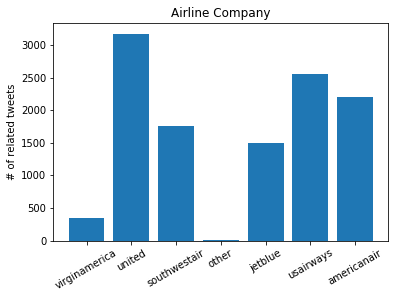

In [62]:
# plot a histogram
x = Counter(airline_list)
l = range(len(x.keys()))
plt.bar(l, x.values(), align='center')
plt.xticks(l, x.keys(), rotation=30)
plt.ylabel('# of related tweets')
plt.title('Airline Company')

**Therefore, we have a general idea about how many tweets are related to certain airline companies. According to the histogram above, United tweets are the most, and VirginAmerica has the fewest related tweets. But what if we want to know, out of those airline tweets, how many of them are positive and negative?**

In [14]:
tweet_VirginAmerica_count

{'negative': 181, 'positive': 147}

In [58]:
# here we define a function to plot stacked bar plot, source cited in comment
# sources: https://stackoverflow.com/questions/44309507/stacked-bar-plot-using-matplotlib
def stacked_bar(data, series_labels, category_labels=None, 
                show_values=False, value_format="{}", y_label=None, 
                grid=True, reverse=False):

    ny = len(data[0])
    ind = list(range(ny))
    axes = []
    cum_size = np.zeros(ny)
    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        axes.append(plt.bar(ind, row_data, bottom=cum_size, label=series_labels[i]))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)

    plt.legend()

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

In [16]:
# get number of positive count for each company
positive_list = []
positive_list.append(tweet_VirginAmerica_count["positive"])
positive_list.append(tweet_United_count["positive"])
positive_list.append(tweet_SouthwestAir_count["positive"])
positive_list.append(tweet_JetBlue_count["positive"])
positive_list.append(tweet_USAirways_count["positive"])
positive_list.append(tweet_AmericanAir_count["positive"])
positive_list.append(tweet_Other_count["positive"])

# get number of negative count for each company
negative_list = []
negative_list.append(tweet_VirginAmerica_count["negative"])
negative_list.append(tweet_United_count["negative"])
negative_list.append(tweet_SouthwestAir_count["negative"])
negative_list.append(tweet_JetBlue_count["negative"])
negative_list.append(tweet_USAirways_count["negative"])
negative_list.append(tweet_AmericanAir_count["negative"])
negative_list.append(tweet_Other_count["negative"])

**[PLOT] US_Airline_tweets histogram for each company with corresponding positive and negative partition**

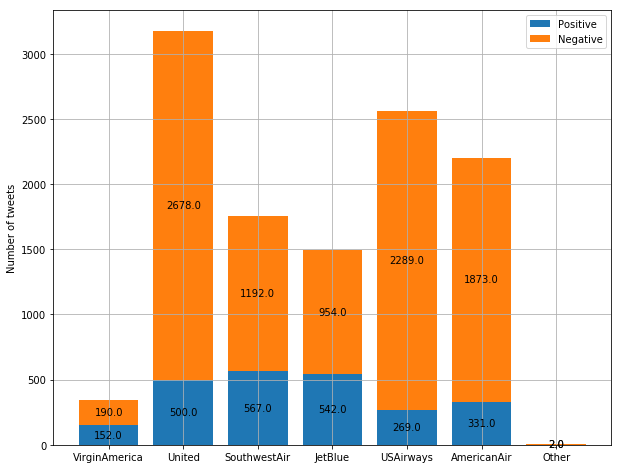

In [17]:
plt.figure(figsize=(10, 8))
series_labels = ['Positive', 'Negative']
data = [positive_list, negative_list]
category_labels = ['VirginAmerica', 'United', 'SouthwestAir', 'JetBlue', 'USAirways', 'AmericanAir','Other']

stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    y_label="Number of tweets"
)

plt.show()

We can see that majority of tweets for each airline company are positive except VirginAmerica (190 vs 152)

**[PLOT] Generic_tweets histogram for most common 10 words in positive tweets**

In [20]:
### generic tweet plot
#Generic_tweets_df
word_counter_positive = Counter()
word_counter_negative = Counter()
tokenizer = RegexpTokenizer(r'\w+')
for i in range(100000,200000):
    positive_words = tokenizer.tokenize(Generic_tweets_df.iat[i,0])
    word_counter_positive.update(positive_words)
for i in range(100000):
    negative_words = tokenizer.tokenize(Generic_tweets_df.iat[i,0])
    word_counter_negative.update(negative_words)

positive_common_word_list = []
positive_common_word_count = []

negative_common_word_list = []
negative_common_word_count = []
for i in range(10):
    positive_common_word_list.append(word_counter_positive.most_common(10)[i][0])
    positive_common_word_count.append(word_counter_positive.most_common(10)[i][1])
    negative_common_word_list.append(word_counter_negative.most_common(10)[i][0])
    negative_common_word_count.append(word_counter_negative.most_common(10)[i][1])

<BarContainer object of 10 artists>

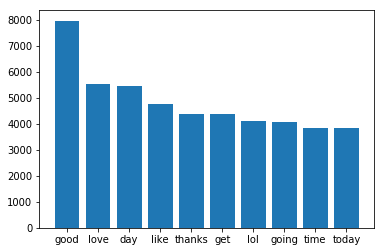

In [22]:
plt.bar(positive_common_word_list, positive_common_word_count)

**[PLOT] Generic_tweets histogram for most common 10 words in negative tweets**

<BarContainer object of 10 artists>

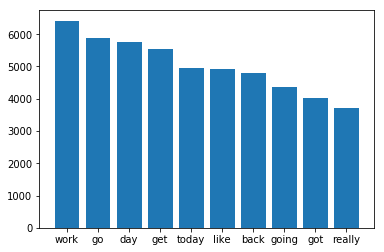

In [23]:
plt.bar(negative_common_word_list, negative_common_word_count)

Interestingly, we ntoiced that word "like" appears in both top 10 most common word for positive and negative tweets. However, the sentimental meaning might be different, further analysis will be shown.

**[BONUS - PLOT] Generic_tweets word cloud for most common words - positive**

In [69]:
generic_tweets_positive = Generic_tweets_df[Generic_tweets_df.target == 1]
generic_tweets_positive_string = []
for t in generic_tweets_positive.text:
    generic_tweets_positive_string.append(t)
generic_tweets_positive_string = pd.Series(generic_tweets_positive_string).str.cat(sep=' ')

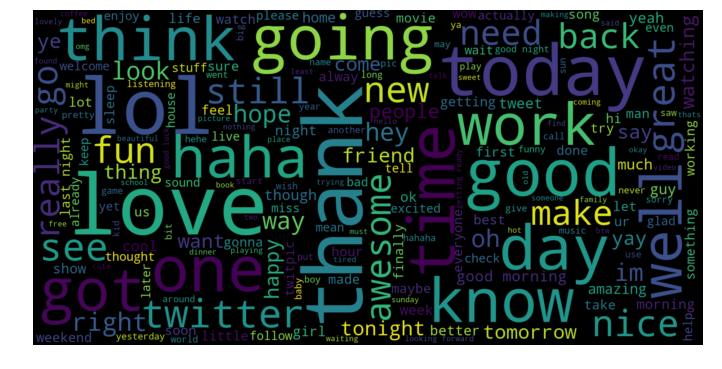

In [70]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(generic_tweets_positive_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**[BONUS - PLOT] Generic_tweets word cloud for most common words - negative**

In [71]:
generic_tweets_negative = Generic_tweets_df[Generic_tweets_df.target == 0]
generic_tweets_negative_string = []
for t in generic_tweets_negative.text:
    generic_tweets_negative_string.append(t)
generic_tweets_negative_string = pd.Series(generic_tweets_negative_string).str.cat(sep=' ')

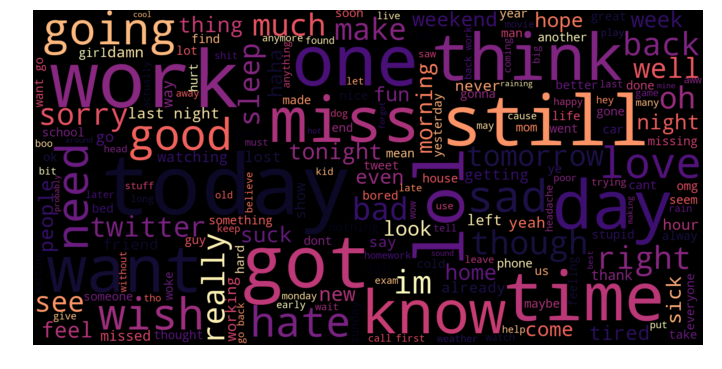

In [72]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(generic_tweets_negative_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Model Preparation 

In [18]:
# in this assignment, words in corpus.txt will be used as features, and 
# term frequency for each word will be used as 1st part feature value

# load corpus info
corpus_pd = pd.read_csv("corpus.txt", sep='\t',header=None)
corpus_pd.columns = ["word", "score"]

corpus_word_list = corpus_pd["word"].tolist()
corpus_score_list = corpus_pd["score"].tolist()

# initiate count vectorizer for each word in corpus word
matrix_term_frequency_cv = CountVectorizer(analyzer = "word", vocabulary=corpus_word_list)

In [20]:
# get term_frequency matrix for generic tweets, this is the first step of train matrix
generic_term_frequency = matrix_term_frequency_cv.fit_transform(Generic_tweets_df["text"])

# turn the large and sparse matrix into a sparse-matrix
generic_sparse_matrix = sp.sparse.csr_matrix(generic_term_frequency)

# load corpus word score as the magnitude (degree) of featured words
corpus_score_sparse = sp.sparse.csr_matrix(corpus_score_list)

# we multiply the term frequency matrix with corpus score to emphasis those more valuable words
final_generic_sparse_matrix = generic_sparse_matrix.multiply(corpus_score_sparse)

# turn sparse-matrix back to dense matrix
final_generic_dense_matrix = final_generic_sparse_matrix.toarray()

# reformulate featur matrix into dataframe ready for training
final_generic_feature_matrix = pd.DataFrame(final_generic_dense_matrix,columns = corpus_word_list)

In [19]:
# we repeat exactly same steps as above cell for us_airline tweets to get a final term frequency matrix
usairline_term_frequency = matrix_term_frequency_cv.fit_transform(USAirline_tweets_df["text"])
usairline_sparse_matrix = sp.sparse.csr_matrix(usairline_term_frequency)
corpus_score_sparse = sp.sparse.csr_matrix(corpus_score_list)
final_usairline_sparse_matrix = usairline_sparse_matrix.multiply(corpus_score_sparse)
final_usairline_dense_matrix = final_usairline_sparse_matrix.toarray()
final_usairline_feature_matrix = pd.DataFrame(final_usairline_dense_matrix,columns = corpus_word_list)

In [21]:
# get test data (ground truth)
y_generic = Generic_tweets_df["target"].tolist()
y_usairline = USAirline_tweets_df["target"].tolist()

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(final_generic_feature_matrix, y_generic, test_size=0.3, random_state=42)

## 4. Model implementation

### Baseline model training

In [76]:
# train a logistic regression classifier
# set C=1 from hyperparameter tunning in the later section
clf = LogisticRegression(C=1).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.6842857142857143
Test accuracy: 0.6770666666666667


We optain a train accuracy of 0.6843 and test accuracy of 0.6771 for Generic tweet.

**[BONUS - PLOT] Visually display the result of logistic regression model on Generic Data - ROC**

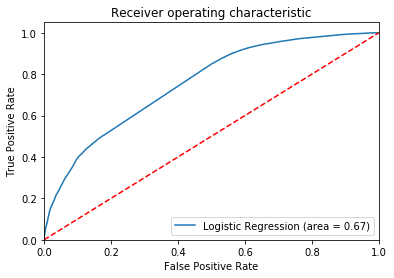

In [184]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Test on USAirline Tweets

In [24]:
# predict on train and test set
y_usairline_predict = clf.predict(final_usairline_feature_matrix)

# calculate train and test accuracy
us_accuracy = accuracy_score(y_usairline_predict, y_usairline)

# report results
print("us_accuracy: {}".format(us_accuracy))


us_accuracy: 0.6764578459405598


We optained us_accuracy of 0.6765

**[BONUS - PLOT] Visually display the result of logistic regression model on USAirline Data - ROC**

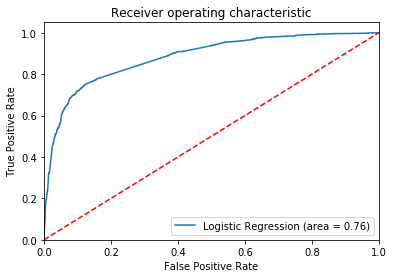

In [186]:
logit_roc_auc = roc_auc_score(y_usairline, clf.predict(final_usairline_feature_matrix))
fpr, tpr, thresholds = roc_curve(y_usairline, clf.predict_proba(final_usairline_feature_matrix)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

**[BONUS - Hyper-parameter Tunning] For baseline logistic regression**

In [18]:
def hyperparameter(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # c to control penalizing large weight on loss function
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        
        # train a logistic regression classifier
        clf = LogisticRegression(C=param).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        
        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

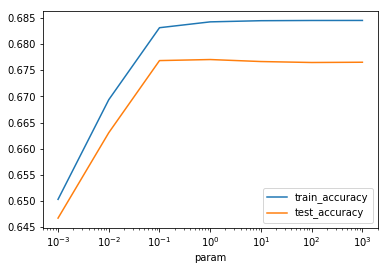

In [19]:
param_df = hyperparameter(final_generic_feature_matrix, y_generic)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

It turns out the test accuracy is still the best at default C=1 level, so we will still use C = 1.
Note that best hyper parameter tunning and model performance should be done using nested cross validation, but due to time and laptop memory ram limit, the work could be extended in the future.

**[BONUS - Classifier] KNN**

In [91]:
clf_knn = KNeighborsClassifier(n_neighbors=20).fit(X_train, y_train)

# predict on train and test set
y_train_predict_knn = clf.predict(X_train)
y_test_predict_knn = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy_knn = accuracy_score(y_train, y_train_predict)
test_accuracy_knn = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy knn: {}".format(train_accuracy_knn))
print("Test accuracy knn: {}".format(test_accuracy_knn))

Train accuracy knn: 0.6842857142857143
Test accuracy knn: 0.6770666666666667


### US tweets negative reason

In [50]:
# check unique negative reasons
USAirline_tweets_df["negative_reason"].unique()

array([nan, 'Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

In [79]:
# extract negative tweets from us airline tweets, note we extract from item-frequency matrix
negative_index = USAirline_tweets_df.index[USAirline_tweets_df["negative_reason"].notnull()].tolist()
negative_usairline_feature_matrix = final_usairline_feature_matrix.iloc[negative_index,:]

In [80]:
# extract negative reason target list
negative_reason_df = USAirline_tweets_df[(USAirline_tweets_df["negative_reason"].notnull())]
negative_reason_list = negative_reason_df['negative_reason'].tolist()

In [81]:
# split to train and test set
X_train_mul, X_test_mul, y_train_mul, y_test_mul = train_test_split(negative_usairline_feature_matrix, negative_reason_list, test_size=0.3, random_state=42)

# use default one-vs-rest(all) logistic regression to train the model
mul_lr = LogisticRegression().fit(X_train_mul, y_train_mul)
#normal_lr = LogisticRegression.fit(X_train_mul, y_train_mul)

In [82]:
# predict on train and test set
y_train_predict_mul = mul_lr.predict(X_train_mul)
y_test_predict_mul = mul_lr.predict(X_test_mul)

# calculate train and test accuracy
train_accuracy_mul = accuracy_score(y_train_mul, y_train_predict_mul)
test_accuracy_mul = accuracy_score(y_test_mul, y_test_predict_mul)

# report results
print("Multinomial Logistic regression Train accuracy: {}".format(train_accuracy_mul))
print("Multinomial Logistic regression Test accuracy: {}".format(test_accuracy_mul))

Multinomial Logistic regression Train accuracy: 0.524906600249066
Multinomial Logistic regression Test accuracy: 0.4531590413943355


**Multiclass with 10 classes has low accuracy, now we try to combine classes with similar reasons**

In [83]:
negative_reason_list_new = []
for i in range(len(negative_reason_list)):
    if negative_reason_list[i] == "Bad Flight" or negative_reason_list[i] == "Late Flight" or negative_reason_list[i] == "Cancelled Flight" or negative_reason_list[i] == "Flight Booking Problems":
        negative_reason_list_new.append(1)
    elif negative_reason_list[i] == "Customer Service Issue" or negative_reason_list[i] == "Flight Attendant Complaints" or negative_reason_list[i] == "longlines":
        negative_reason_list_new.append(2)
    elif negative_reason_list[i] == "Lost Luggage" or negative_reason_list[i] == "Damaged Luggage":
        negative_reason_list_new.append(3)
    else:
        negative_reason_list_new.append(4)

In [86]:
# split to train and test set
X_train_mul2, X_test_mul2, y_train_mul2, y_test_mul2 = train_test_split(negative_usairline_feature_matrix, negative_reason_list_new, test_size=0.3, random_state=42)
mul_lr2 = LogisticRegression().fit(X_train_mul2, y_train_mul2)

# predict on train and test set
y_train_predict_mul2 = mul_lr2.predict(X_train_mul2)
y_test_predict_mul2 = mul_lr2.predict(X_test_mul2)

# calculate train and test accuracy
train_accuracy_mul2 = accuracy_score(y_train_mul2, y_train_predict_mul2)
test_accuracy_mul2 = accuracy_score(y_test_mul2, y_test_predict_mul2)

# report results
print("Multinomial Logistic regression Train accuracy: {}".format(train_accuracy_mul2))
print("Multinomial Logistic regression Test accuracy: {}".format(test_accuracy_mul2))

Multinomial Logistic regression Train accuracy: 0.599159402241594
Multinomial Logistic regression Test accuracy: 0.5257806826434277


The test accuracy increased as we combine classes, however the performance still not good/

**[BONUS - Cross validation training & PLOT] - using cross validation for multi-class logistic regression to improve model performance with ROC plot**

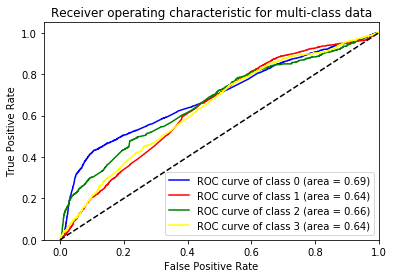

In [193]:
# plot source : https://stackoverflow.com/questions/45641409/computing-scikit-learn-multiclass-roc-curve-with-cross-validation-cv
# Binarize the output
y_bin = label_binarize(negative_reason_list_new, classes=[1, 2, 3, 4])
n_classes = y_bin.shape[1]

pipe= Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression())])

# we set a 10-fold cross validation training 
y_score = cross_val_predict(pipe, negative_usairline_feature_matrix, negative_reason_list_new, cv=10 ,method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

The logistic regression model performance hase been increased after cross validation and hyper-parameter tunning.

## 5. Discussion

 * the Baseline logistic regression model yield a test accuracy of 0.6771
 * Hyper parameter tunning (c) on baseline model verified that C=1 yields the best result.
 * Noteworthy, baseline model performs well on unseen us_airline tweets with test accuracy of 0.6745. It means althouth the general accuracy is not that good, unseen test accuracy still close enough with model test accuracy - model was not overfit.
 * for alternative classifiers: KNN with k =20 outputs Test accuracy 0.6771, same as baseline. 
 * for negative reason prediction, baseline multiclass logistic regression only got 0.4532 test accuracy. After combine similar reasons, classes became from 10 to 4, test accuracy increased to 0.5258. After using 10-fold cross validation, the test accuracy increased to almost 0.65.

**How each airline is viewed under public eye based on sentiment value?**

we plot the stacked bar chart from the result of us_airline_tweet prediction.

In [26]:
se = pd.Series(y_usairline_predict)
USAirline_tweets_df['public view'] = se.values

In [ ]:
# put each tweet in to corresponding airline list
airline_list = []
tweet_VirginAmerica = []
tweet_United = []
tweet_SouthwestAir = []
tweet_JetBlue = []
tweet_USAirways = []
tweet_AmericanAir = []
tweet_Other = []

tweet_VirginAmerica_count={}
tweet_VirginAmerica_count["negative"]=0
tweet_VirginAmerica_count["positive"]=0

tweet_United_count={}
tweet_United_count["negative"]=0
tweet_United_count["positive"]=0

tweet_SouthwestAir_count={}
tweet_SouthwestAir_count["negative"]=0
tweet_SouthwestAir_count["positive"]=0

tweet_JetBlue_count={}
tweet_JetBlue_count["negative"]=0
tweet_JetBlue_count["positive"]=0

tweet_USAirways_count={}
tweet_USAirways_count["negative"]=0
tweet_USAirways_count["positive"]=0

tweet_AmericanAir_count={}
tweet_AmericanAir_count["negative"]=0
tweet_AmericanAir_count["positive"]=0

tweet_Other_count={}
tweet_Other_count["negative"]=0
tweet_Other_count["positive"]=0

for i in range(USAirline_tweets_df.shape[0]):
    airline = airline_name(USAirline_tweets_df.iat[i,0])[0]
    airline_list.append(airline)
    if airline == "virginamerica":
        tweet_VirginAmerica.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,3] == 1:
            tweet_VirginAmerica_count["positive"] += 1
        else:
            tweet_VirginAmerica_count["negative"] += 1
            
    elif airline == "united":
        tweet_United.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,3] == 1:
            tweet_United_count["positive"] += 1
        else:
            tweet_United_count["negative"] += 1
            
    elif airline == "southwestair":
        tweet_SouthwestAir.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,3] == 1:
            tweet_SouthwestAir_count["positive"] += 1
        else:
            tweet_SouthwestAir_count["negative"] += 1
            
    elif airline == "jetblue":
        tweet_JetBlue.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,3] == 1:
            tweet_JetBlue_count["positive"] += 1
        else:
            tweet_JetBlue_count["negative"] += 1
            
    elif airline == "usairways":
        tweet_USAirways.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,3] == 1:
            tweet_USAirways_count["positive"] += 1
        else:
            tweet_USAirways_count["negative"] += 1
            
    elif airline == "americanair":
        tweet_AmericanAir.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,3] == 1:
            tweet_AmericanAir_count["positive"] += 1
        else:
            tweet_AmericanAir_count["negative"] += 1
    
    elif airline == "other":
        tweet_Other.append(USAirline_tweets_df.iat[i,0])
        if USAirline_tweets_df.iat[i,3] == 1:
            tweet_Other_count["positive"] += 1
        else:
            tweet_Other_count["negative"] += 1
            
positive_list = []
positive_list.append(tweet_VirginAmerica_count["positive"])
positive_list.append(tweet_United_count["positive"])
positive_list.append(tweet_SouthwestAir_count["positive"])
positive_list.append(tweet_JetBlue_count["positive"])
positive_list.append(tweet_USAirways_count["positive"])
positive_list.append(tweet_AmericanAir_count["positive"])
positive_list.append(tweet_Other_count["positive"])

negative_list = []
negative_list.append(tweet_VirginAmerica_count["negative"])
negative_list.append(tweet_United_count["negative"])
negative_list.append(tweet_SouthwestAir_count["negative"])
negative_list.append(tweet_JetBlue_count["negative"])
negative_list.append(tweet_USAirways_count["negative"])
negative_list.append(tweet_AmericanAir_count["negative"])
negative_list.append(tweet_Other_count["negative"])

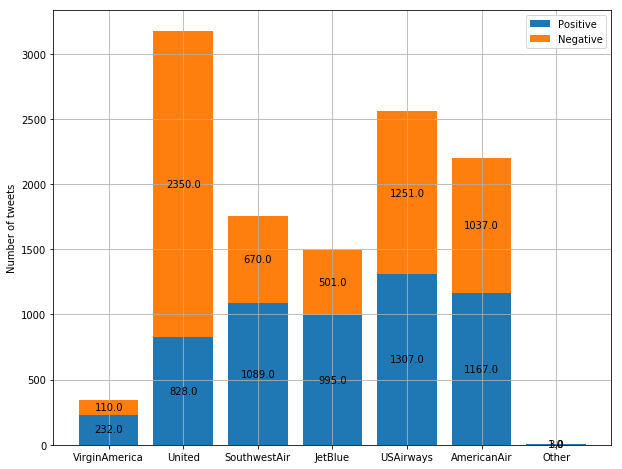

In [55]:
plt.figure(figsize=(10, 8))
series_labels = ['Positive', 'Negative']
data = [positive_list, negative_list]
category_labels = ['VirginAmerica', 'United', 'SouthwestAir', 'JetBlue', 'USAirways', 'AmericanAir','Other']

stacked_bar2(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    y_label="Number of tweets"
)

plt.show()

We can see that according to our prediction, general public view on most airlines are in negative sentiment. For Virginamerica, almso 2/3 of the public have a negative attitude while United is doing the best by having most portion of positive sentiment.

In [92]:
# newly aggregated test est matrix
USAirline_tweets_df.head(20)

,text,target,negative_reason,public view
0,virginamerica plus added commercials experienc...,1,NaN,1
1,virginamerica really aggressive blast obnoxiou...,0,Bad Flight,0
2,virginamerica really big bad thing,0,Can't Tell,0
3,virginamerica seriously would pay 30 flight se...,0,Can't Tell,0
4,virginamerica yes nearly every time fly vx â œ...,1,NaN,1
5,virginamerica well tâ,1,NaN,1
6,virginamerica amazing arrived hour early good,1,NaN,1
7,virginamerica 3 pretty graphics much better mi...,1,NaN,1
8,virginamerica great deal already thinking 2nd ...,1,NaN,1
9,virginamerica virginmedia flying fabulous sedu...,1,NaN,1


In [93]:
# wrongly classified example
USAirline_tweets_df["text"][16]

'virginamerica first fares may three times carriers seats available select'

**wrongly classified example**
'virginamerica first fares may three times carriers seats available select'

this tweet got classified as positive but acutally negative due to "three" "times" words mis-leading the negative meaning, however the reason of negative is "can't tell", still hard to define.


**Suggestions to improve model 1:**

 1. during the training, considering mutual information for feature selection.
 2. can also use most common word eg top 1000 for features and multiply corpus score in term-frequency matrix
 3. gather more number of tweets will definitely help improve performance
 4. nestive cross validation to tune best parameter with best model performance
 
**Suggestions to improve model 2:**
 
 1. try to balance the data for each class after combining the classes, unbalanced data will largely affect performance
 2. cannot simply balance the data since we combine the classes due to similar reasons
 3. use deep learning may find local optimum but better than current accuracy.